# IMPORT LIBRARY

In [11]:
# Memuat library-library yang dibutuhkan
import numpy as np
import pandas as pd
import os
import cv2
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

# TensorFlow Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from keras.layers import Dense, Dropout
from tensorflow.keras import Model

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow.keras.applications')

# IMPORT DATASET

In [12]:
# Menyiapkan direktori dataset
dir = 'D:/sem 7/PCD/PCD-DJ/JAGUNG/Dataset/'

# DATA UNDERSTANDING

In [13]:
# Proses analisis gambar untuk mendapatkan format, ukuran, dan jumlah channel
def analyze_images(directory):
    image_formats = set()
    max_size = (0, 0)
    min_size = (float('inf'), float('inf'))
    channel_count = None
    image_count = 0

    for root, _, files in os.walk(directory):
        for filename in files:
            filepath = os.path.join(root, filename)
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image = cv2.imread(filepath)
                if image is None:
                    continue

                # Dapatkan format gambar
                image_format = filename.split('.')[-1].upper()
                image_formats.add(image_format)
                
                # Dapatkan ukuran gambar
                height, width = image.shape[:2]
                max_size = max(max_size, (width, height))
                min_size = min(min_size, (width, height))

                # Dapatkan jumlah channel
                channels = image.shape[2] if len(image.shape) > 2 else 1
                if channel_count is None:
                    channel_count = channels
                elif channel_count != channels:
                    print("Gambar memiliki jumlah channel yang berbeda.")
                    return

                image_count += 1

    if image_count > 0:
        print(f"Format Data: {', '.join(image_formats)}")
        print(f"Max Ukuran Data: {max_size}")
        print(f"Min Ukuran Data: {min_size}")
        print(f"Ukuran Channel: {channel_count}")
    else:
        print("Tidak ada gambar yang ditemukan.")

# Jalankan analisis
analyze_images(dir)

Format Data: JPG, JPEG
Max Ukuran Data: (5184, 3456)
Min Ukuran Data: (180, 347)
Ukuran Channel: 3


In [14]:
#letak file dan kategori
image_dir = Path(dir)

filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Menggabungkan lokasi letak file dan kategori
image_df = pd.concat([filepaths, labels], axis=1)

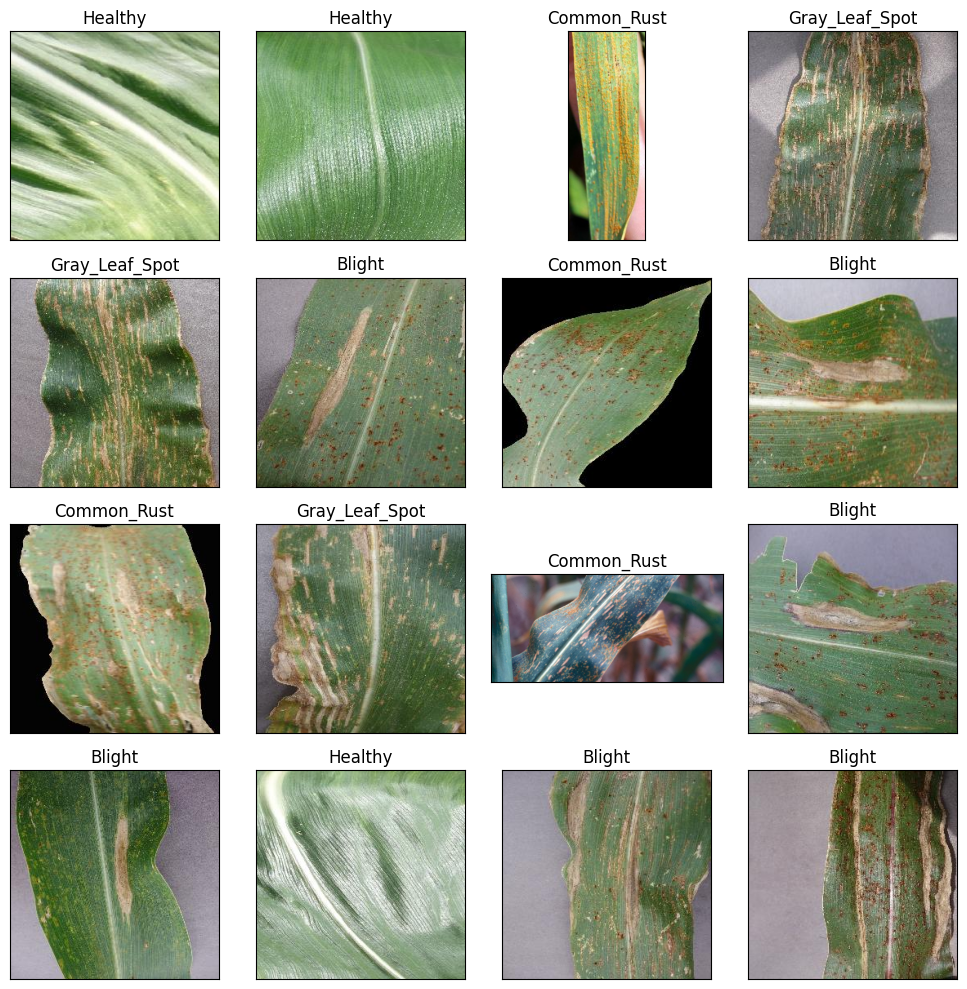

In [15]:
# Menampilkan foto random sesuai kategori
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# DATA PREPARATION

In [16]:
# pemisahan antara data train dan data test
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

# dari total 100% dataset diambil 20% untuk testing

In [17]:
# Membagi dataset menjadi data latih dan data uji
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

# dari sisa 80% dataset diambil 20% untuk val dan sisanya untuk training

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# pembagian dataset
# train 64%
# val 16%
# test 20%

In [18]:
# Membagi data menjadi beberapa kategori data (train, val dan test)
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5360 validated image filenames belonging to 4 classes.
Found 1339 validated image filenames belonging to 4 classes.
Found 1675 validated image filenames belonging to 4 classes.


In [19]:
# Merubah ukuran gambar dan menyesuaikan nilai warna
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(224, 224),
    layers.Rescaling(1./255),
])

# MODELING

In [20]:
# Muat model sebelumnya
pretrained_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

In [21]:
# Membekukan layer dasar MobileNet agar tidak dilatih ulang
pretrained_model.trainable = False

In [22]:
# Membuat model yang akan dilatih ulang
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(4, activation='softmax')(x)

In [23]:
# Membuat model yang akan dilatih ulang, dengan 2 layer Dense dan Dropout 0.2
model = Model(inputs=inputs, outputs=outputs)

In [24]:
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
# Latih model dengan data latih dan validasi
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10
)

C:\Users\Denia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 134s 757ms/step - accuracy: 0.6964 - loss: 0.7688 - val_accuracy: 0.9037 - val_loss: 0.2601
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 134s 796ms/step - accuracy: 0.8987 - loss: 0.2556 - val_accuracy: 0.9141 - val_loss: 0.2111
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 133s 792ms/step - accuracy: 0.9241 - loss: 0.1906 - val_accuracy: 0.9305 - val_loss: 0.1833
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 135s 803ms/step - accuracy: 0.9332 - loss: 0.1654 - val_accuracy: 0.9350 - val_loss: 0.1623
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 136s 811ms/step - accuracy: 0.9498 - loss: 0.1362 - val_accuracy: 0.9425 - val_loss: 0.1553
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 132s 789ms/step - accuracy: 0.9617 - loss: 0.1116 - val_accuracy: 0.9477 - val_loss: 0.1430
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 136s 810ms/step - accuracy: 0.9698 - loss: 0.0863 - val_accuracy: 0.9529 - val_loss: 0.1302
Epoch 8/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 129s 768ms/step - accuracy: 0.9727 -

# EVALUASI

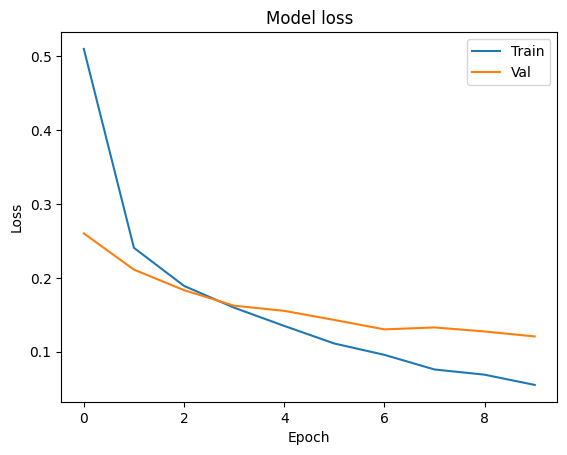

In [26]:
# Membuat plot loss model dengan data latih dan validasi
# untuk memantau kinerja model dalam proses pelatihan
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

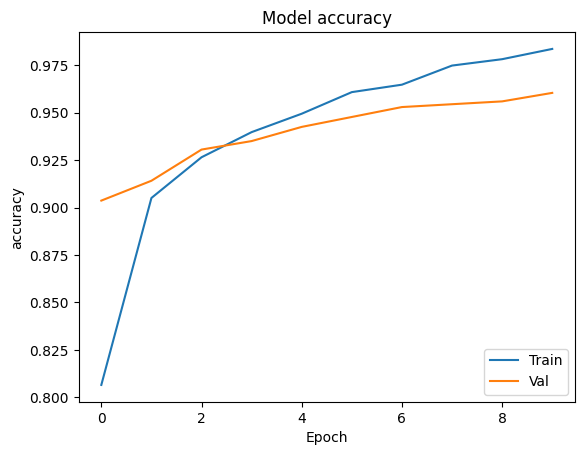

In [27]:
# Membuat plot akurasi dan loss model
# dengan data latih dan validasi
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [28]:
# Prediksi pada data uji
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 649ms/step


In [29]:
# Mendapatkan label sebenarnya
y_true = test_images.classes

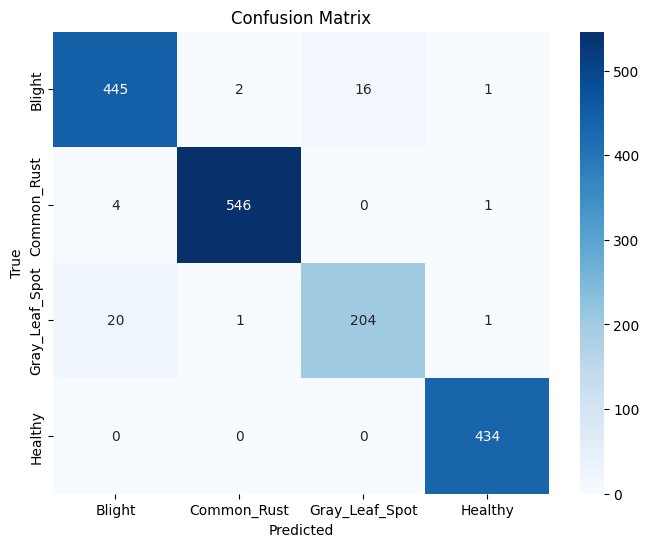

In [30]:
# Menghitung confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Menampilkan confusion matrix menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_images.class_indices.keys(),
            yticklabels=train_images.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [31]:
# Menghitung akurasi model terhadap data uji
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       464
           1       0.99      0.99      0.99       551
           2       0.93      0.90      0.91       226
           3       0.99      1.00      1.00       434

    accuracy                           0.97      1675
   macro avg       0.97      0.96      0.96      1675
weighted avg       0.97      0.97      0.97      1675



In [32]:
# Menghitung akurasi model terhadap data uji
loss, accuracy = model.evaluate(train_images)
print(f'Akurasi Model: {accuracy*100:.2f}%')

168/168 ━━━━━━━━━━━━━━━━━━━━ 101s 600ms/step - accuracy: 0.9935 - loss: 0.0292
Akurasi Model: 99.46%


In [33]:
# Menampilkan akurasi model terhadap data latih dan data validasi
loss, accuracy = model.evaluate(val_images)
print(f'Akurasi Validasi: {accuracy*100:.2f}%')

42/42 ━━━━━━━━━━━━━━━━━━━━ 25s 600ms/step - accuracy: 0.9589 - loss: 0.1319
Akurasi Validasi: 96.04%


In [34]:
# Prediksi label tes gambar
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Peta label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Tampilan Hasil
print(f'The first 4 predictions: {pred[:10]}')

53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 602ms/step
The first 4 predictions: ['Blight', 'Healthy', 'Common_Rust', 'Blight', 'Common_Rust', 'Common_Rust', 'Blight', 'Gray_Leaf_Spot', 'Common_Rust', 'Blight']


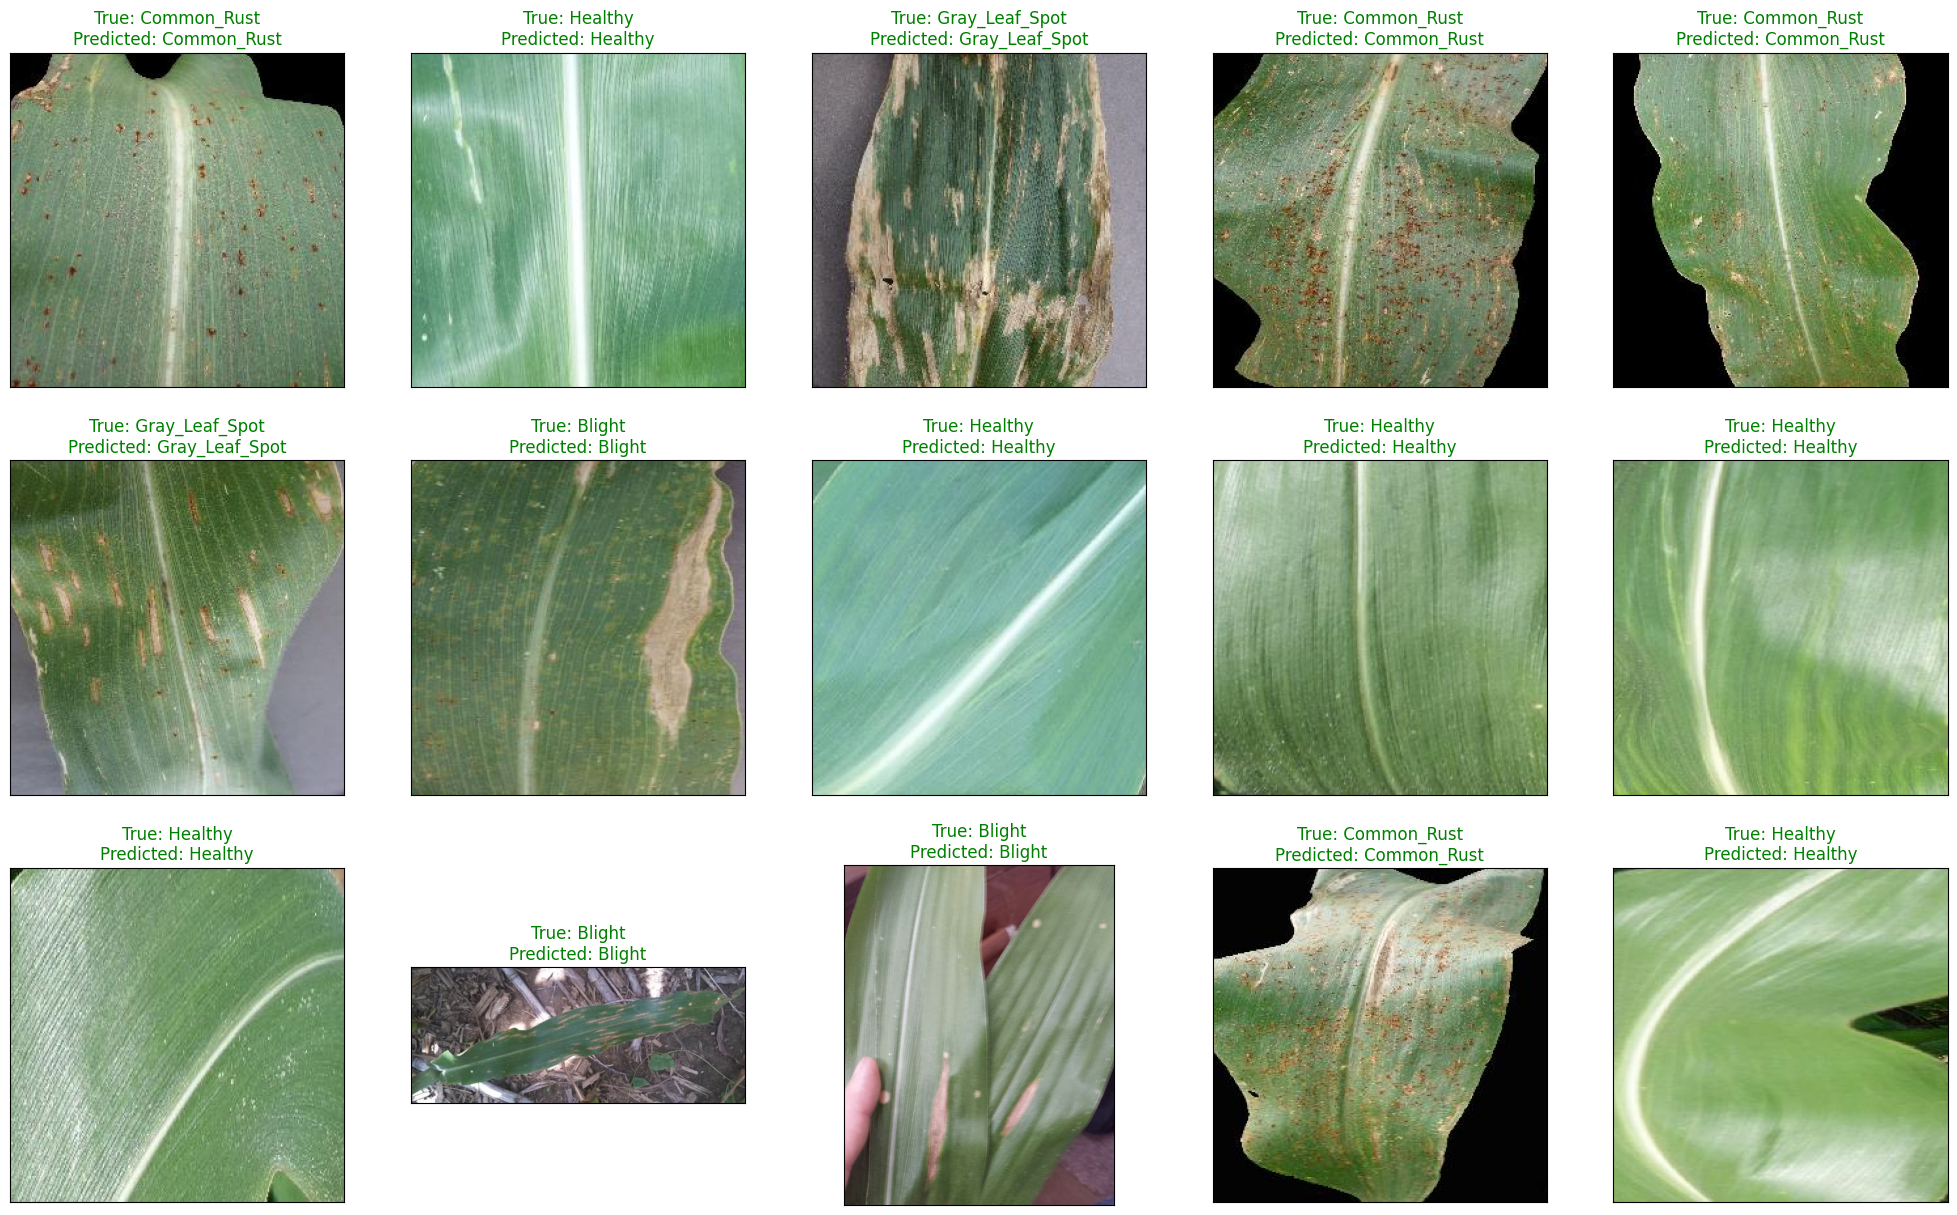

<Figure size 640x480 with 0 Axes>

In [35]:
# Tampilkan 25 gambar acak dari kumpulan data beserta labelnya
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# SAVE MODEL

In [38]:
# Simpan model yang telah di train dalam bentuk file .h5
dir2 = "D:sem 7/PCD/PCD-DJ/JAGUNG/Dataset/"

In [39]:
# Simpan model yang telah di train dalam bentuk file .h5 di direktori yang di tentukan
# agar dapat digunakan kembali pada aplikasi yang akan dibuat
model.save(dir2+"model_jagung.h5")